In [1]:
# TCC: APLICAÇÃO DE MACHINE LEARNING PARA APOSTAS ESPORTIVAS: uso de Regressão Logística,
#      SVM, Árvore de Decisão e Naive Bayes
#
# Aluno: João Henrique
# Orientadora: Renata Alcoforado

In [2]:
# Importando as bibliotecas

import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score , f1_score, precision_score, recall_score
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import  GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import scale
%matplotlib inline

In [3]:
# O arquivo utilizado foi uma compilação com dados baixados do site www.football-data.co.uk, que disponibiliza...
# ... informações de diversos campeonatos ao redor do mundo
# Por meio do Excel foram retirados os jogos em que estavam faltando dados de quaisquer variáveis de interesse...
# ...para o estudo


# Legenda das variáveis:

# Div = Divisão da Liga
# Date = Data do jogo
# HomeTeam = Time da casa
# AwayTeam = Time visitante
# FTR = Resultado do jogo (0 = empate, 1 = vitória do time da casa, 2 = vitória do time visitante)
# B365H = Odd (probablidade) de vitória do time da casa pela Bet365 (casa de apostas)
# B365D = Odd (probablidade) de empate pela Bet365 (casa de apostas)
# B365A = Odd (probablidade) de vitória do time visitante pela Bet365 (casa de apostas)
# BWH = Odd (probablidade) de vitória do time da casa pela Bet&Win (casa de apostas)
# BWD = Odd (probablidade) de empate pela Bet&Win (casa de apostas)
# BWA = Odd (probablidade) de vitória do time visitante pela Bet&Win (casa de apostas)
# IWH = Odd (probablidade) de vitória do time da casa pela Interwetten (casa de apostas)
# IWD = Odd (probablidade) de empate pela Interwetten (casa de apostas)
# IWA = Odd (probablidade) de vitória do time visitante pela Interwetten (casa de apostas)
# PSH = Odd (probablidade) de vitória do time da casa pela Pinnacle (casa de apostas)
# PSD = Odd (probablidade) de empate pela Pinnacle (casa de apostas)
# PSA = Odd (probablidade) de vitória do time visitante pela Pinnacle (casa de apostas)
# VCH = Odd (probablidade) de vitória do time da casa pela VC Bet (casa de apostas)
# VCD = Odd (probablidade) de empate pela VC Bet (casa de apostas)
# VCA = Odd (probablidade) de vitória do time visitante pela VC Bet (casa de apostas)
# WHH = Odd (probablidade) de vitória do time da casa pela William Hill (casa de apostas)
# WHD = Odd (probablidade) de empate pela William Hill (casa de apostas)
# WHA = Odd (probablidade) de vitória do time visitante pela William Hill (casa de apostas)

# Lendo o arquivo FRA10anos.csv
data = pd.read_csv('FRA10anos.csv', delimiter = ',')

# Visualizando a base de dados:
display(data.head())

,Div,Date,HomeTeam,AwayTeam,FTR,B365H,B365D,B365A,BWH,BWD,...,IWA,PSH,PSD,PSA,VCH,VCD,VCA,WHH,WHD,WHA
0,F1,10/08/12,Montpellier,Toulouse,D,1.83,3.40,4.50,1.78,3.40,...,4.2,1.89,3.36,5.02,1.87,3.40,5.00,1.83,3.2,4.80
1,F1,11/08/12,Evian Thonon Gaillard,Bordeaux,A,2.75,3.20,2.60,2.80,3.10,...,2.4,2.93,3.25,2.66,2.90,3.25,2.62,2.75,3.1,2.62
2,F1,11/08/12,Nancy,Brest,H,2.10,3.20,3.60,2.15,3.00,...,3.5,2.16,3.21,3.99,2.15,3.20,4.00,2.15,3.0,3.75
3,F1,11/08/12,Nice,Ajaccio,A,1.91,3.25,4.33,1.90,3.25,...,3.5,1.97,3.32,4.62,1.98,3.30,4.60,2.00,3.1,4.20
4,F1,11/08/12,Paris SG,Lorient,D,1.33,4.75,10.00,1.30,4.75,...,7.5,1.36,5.13,10.67,1.33,4.50,11.50,1.33,4.5,11.00


In [4]:
# Criando a coluna com o identificador do jogo (Game_id)

data = pd.DataFrame(data)
data = data.reset_index()
data = data.rename(columns = {"index": "Game_id"})
data["Game_id"] = data.index + 1


# Alterando os resultados de string (D = empate, H = vitória do time da casa, A = vitória do time visitante), para
# int (0 = empate, 1 = vitória do time da casa, 2 = vitória do time visitante)
for i in range(0,len(data)):
    if data["FTR"][i] == "D":
        data.at[i,"FTR"] = "0"
    if data["FTR"][i] == "H":
        data.at[i,"FTR"] = "1"
    if data["FTR"][i] == "A":
        data.at[i,"FTR"] = "2"

data["FTR"] = data["FTR"].astype(str).astype(int)

# Verificando as 5 primeiras linhas do arquivo após os primeiros ajustes
display(data.head())

,Game_id,Div,Date,HomeTeam,AwayTeam,FTR,B365H,B365D,B365A,BWH,...,IWA,PSH,PSD,PSA,VCH,VCD,VCA,WHH,WHD,WHA
0,1,F1,10/08/12,Montpellier,Toulouse,0,1.83,3.40,4.50,1.78,...,4.2,1.89,3.36,5.02,1.87,3.40,5.00,1.83,3.2,4.80
1,2,F1,11/08/12,Evian Thonon Gaillard,Bordeaux,2,2.75,3.20,2.60,2.80,...,2.4,2.93,3.25,2.66,2.90,3.25,2.62,2.75,3.1,2.62
2,3,F1,11/08/12,Nancy,Brest,1,2.10,3.20,3.60,2.15,...,3.5,2.16,3.21,3.99,2.15,3.20,4.00,2.15,3.0,3.75
3,4,F1,11/08/12,Nice,Ajaccio,2,1.91,3.25,4.33,1.90,...,3.5,1.97,3.32,4.62,1.98,3.30,4.60,2.00,3.1,4.20
4,5,F1,11/08/12,Paris SG,Lorient,0,1.33,4.75,10.00,1.30,...,7.5,1.36,5.13,10.67,1.33,4.50,11.50,1.33,4.5,11.00


Total de jogos:  3681
Total de colunas:  24
Total de jogos ganhos em casa:  1633
Total de jogos ganhos pelo visitante:  1076
Total de jogos empatados:  972
Percentual de jogos ganhos em casa: 44.36%


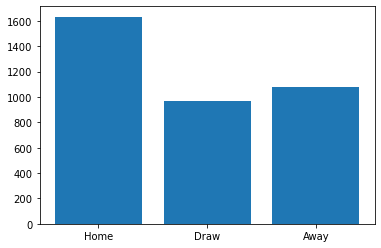

In [5]:
# Explorando a base de dados de dos campeonatos de 2012/2013 a 2021/2022 (últimas 10 temporadas completas)

# Na temporada 2019/2020 devido a pandemia de Covid-19 o campeonato foi encerrado com 10 rodadas de antecedência e...
#...também ficou faltando o jogo de conclusão da 28ª rodada entre o Strasbourg e o Paris Saint-Germain...
# Totalizando 279 partidas neste campeonato em relação aos 380 jogos dos demais anos.

# Além disso 18 linhas da base de dados foram retiradas por falta de algumas informações necessárias de variáveis

matches = data.shape[0]
features = data.shape[1]

home_win = len(data[data.FTR==1])
away_win = len(data[data.FTR==2])
draw = len(data[data.FTR==0])
val = [home_win, draw, away_win]

win_rate = (float(home_win)/(matches)) *100

print ('Total de jogos: ', matches)
print ('Total de colunas: ', features)
print ('Total de jogos ganhos em casa: ', home_win)
print ('Total de jogos ganhos pelo visitante: ', away_win)
print ('Total de jogos empatados: ', draw)
print ('Percentual de jogos ganhos em casa: {:.2f}%'.format( win_rate ))

x = np.arange(3)
plt.bar(x, val)
plt.xticks(x, ('Home', 'Draw', 'Away'))
plt.show()

In [6]:
# Separando as features e as labels

features = data[['B365H', 'B365D', 'B365A', 'BWH', 'BWD', 'BWA', 'IWH', 'IWD', 'IWA', 'PSH', 'PSD', 'PSA', 'VCH', 'VCD', 'VCA', 'WHH', 'WHD', 'WHA']]
labels = data['FTR']

print('Features')
print(features.head())
print('=====================')
print('Labels')
print(labels.head())

Features
   B365H  B365D  B365A   BWH   BWD    BWA   IWH   IWD  IWA   PSH   PSD    PSA  \
0   1.83   3.40   4.50  1.78  3.40   4.60  1.80  3.25  4.2  1.89  3.36   5.02   
1   2.75   3.20   2.60  2.80  3.10   2.55  2.80  3.10  2.4  2.93  3.25   2.66   
2   2.10   3.20   3.60  2.15  3.00   3.70  2.00  3.15  3.5  2.16  3.21   3.99   
3   1.91   3.25   4.33  1.90  3.25   4.25  2.00  3.15  3.5  1.97  3.32   4.62   
4   1.33   4.75  10.00  1.30  4.75  10.50  1.37  4.25  7.5  1.36  5.13  10.67   

    VCH   VCD    VCA   WHH  WHD    WHA  
0  1.87  3.40   5.00  1.83  3.2   4.80  
1  2.90  3.25   2.62  2.75  3.1   2.62  
2  2.15  3.20   4.00  2.15  3.0   3.75  
3  1.98  3.30   4.60  2.00  3.1   4.20  
4  1.33  4.50  11.50  1.33  4.5  11.00  
Labels
0    0
1    2
2    1
3    2
4    0
Name: FTR, dtype: int32


In [7]:
# Normalizando os dados de entrada (features)

scaler = MinMaxScaler().fit(features)
features_scale = scaler.transform(features)

print('Features: ',features_scale.shape)
print(features_scale)

Features:  (3681, 18)
[[0.03909774 0.10769231 0.1025251  ... 0.04006009 0.078125   0.09273183]
 [0.08521303 0.09230769 0.04472163 ... 0.08612919 0.0703125  0.03809524]
 [0.05263158 0.09230769 0.07514451 ... 0.05608413 0.0625     0.06641604]
 ...
 [0.07769424 0.11538462 0.04533009 ... 0.07611417 0.1015625  0.03809524]
 [0.0075188  0.5        0.26985093 ... 0.00851277 0.375      0.27318296]
 [0.14786967 0.13461538 0.02190447 ... 0.14872308 0.125      0.01754386]]


In [8]:
# Separação de treino e teste, feita manualmente para manter a ordem cronológica, uma vez que...
# ... temos informação temporal.
# Treino [:2944]     representa aproximadamente 80% dos dados
# Teste [2944:3312]      representa aproximadamente 10% dos dados
# Previsão [3312:3681]     representa aproximadamente 10% dos dados


X_train = features_scale[:2944]
X_test = features_scale[2944:3312]
y_train = labels[:2944]
y_test = labels[2944:3312]

print(len(X_train), len(y_train))
print(len(X_test), len(y_test))

2944 2944
368 368


In [9]:
# Rodando o modelo de Regressão Logística em sua versão multinomial

clf_LR = LogisticRegression(multi_class = 'multinomial', max_iter = 2000)
clf_LR.fit(X_train, y_train)
pred = clf_LR.predict(X_test)

lr_acc = accuracy_score(y_test, pred)
f1 = f1_score(y_test, pred, average = 'micro')

print('Regressão Logística')
print('')
print('Acurácia: {:.2f}%'.format(lr_acc*100))
print('F1 Score: {:.2f}%'.format(f1*100))

Regressão Logística

Acurácia: 48.64%
F1 Score: 48.64%


In [10]:
# Rodando o modelo de Support Vector Machine (SVM)

clf_SVM = SVC()
clf_SVM.fit(X_train, y_train)
pred = clf_SVM.predict(X_test)

svm_acc = accuracy_score(y_test, pred)
f1 = f1_score(y_test, pred, average = 'micro')

print('SVM')
print('')
print('Acurácia: {:.2f}%'.format(svm_acc*100))
print('F1 Score: {:.2f}%'.format(f1*100))

SVM

Acurácia: 48.64%
F1 Score: 48.64%


In [11]:
# Rodando o modelo de Árvore de Decisão

clf_DT = DecisionTreeClassifier(random_state=42)
clf_DT.fit(X_train, y_train)
pred = clf_DT.predict(X_test)

dt_acc = accuracy_score(y_test, pred)
f1 = f1_score(y_test, pred, average = 'macro')

print('Árvore de Decisão')
print('')
print('Acurácia: {:.2f}%'.format(dt_acc*100))
print('F1 Score: {:.2f}%'.format(f1*100))

Árvore de Decisão

Acurácia: 41.85%
F1 Score: 40.38%


In [12]:
# Rodando o modelo de Naive Bayes

clf_NB = GaussianNB()
clf_NB.fit(X_train, y_train)
pred = clf_NB.predict(X_test)

nb_acc = accuracy_score(y_test, pred)
f1 = f1_score(y_test, pred, average = 'micro')

print('Naive Bayes')
print('')
print('Acurácia Naive Bayes: {:.2f}%'.format(nb_acc*100))
print('F1 Score: {:.2f}%'.format(f1*100))

Naive Bayes

Acurácia Naive Bayes: 40.22%
F1 Score: 40.22%


In [13]:
#Executando a previsão pelo método de maior acurácia (Regressão Logística)

previsao = features_scale[3312:]

game_id_full = data['Game_id']
game_id_prev = game_id_full[3312:]

res_full = data['FTR']
res_prev = res_full[3312:]

pred = clf_LR.predict(previsao)

df = pd.DataFrame({'Real': res_prev, 'Previsão': pred, 'Game_id': game_id_prev})

print(df)

      Real  Previsão  Game_id
3312     1         2     3313
3313     2         1     3314
3314     1         1     3315
3315     1         2     3316
3316     0         2     3317
...    ...       ...      ...
3676     0         1     3677
3677     1         1     3678
3678     0         1     3679
3679     1         1     3680
3680     2         2     3681

[369 rows x 3 columns]


<AxesSubplot:xlabel='Previsão', ylabel='Real'>

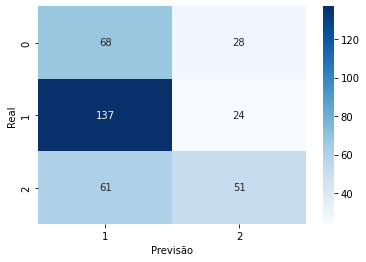

In [14]:
#confusion Matrix

df = pd.DataFrame(df,columns = ['Real','Previsão'])

cf_matrix = pd.crosstab(df['Real'], df['Previsão'], rownames = ['Real'] , colnames = ['Previsão'])

sns.heatmap(cf_matrix, annot = True, cmap = 'Blues', fmt = 'g')